In [34]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

## Piecewise Regression

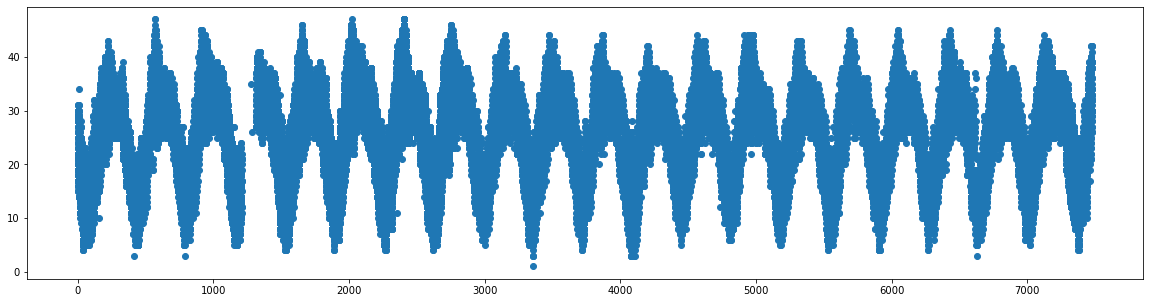

In [35]:
data = np.loadtxt("spline_data.csv",delimiter=",",skiprows=1)
X = data[:,0]
Y = data[:,1]
plt.figure(figsize=(20,5))
plt.scatter(X,Y)

In [36]:
# implement piecewise polynomial regression here

def partition_data(X,Y,knots):
    # split the data into bins
    order = np.argsort(X)
    X = X[order]
    Y = Y[order]
    bins = np.digitize(X,knots)
    return bins, X, Y

# fit a polynomial with the given order to the data. Compute the closed form solution, do not use np.polyfit or similar functions
def fit_polynomial(X,Y,order):
    #w = 187
    A = np.vander(X, order + 1)
    ATA = np.dot(A.T, A)
    ATY = np.dot(A.T, Y)
    w = np.linalg.solve(ATA, ATY)
    return w

def evaluate_polynomial(X,w,order):
    # evaluate the polynomial
    #Y_pred = 696969696969
    X_power = np.vander(X, order + 1)
    Y_pred = np.dot(X_power, w)
    return Y_pred

# fit a local polynomial with the given order to the data
# return the predicted values
def fit_local_polynomial(X,Y,order,knots):
    # fit a local polynomial with the given order to the data
    bins, X, Y = partition_data(X,Y,knots)
    Y_pred = np.zeros_like(Y)
    # fill in code here
    for i in range(0, len(np.unique(bins))):
#         print(i)
        indices = np.where(bins == i)[0]
        local_X = X[indices]
        local_Y = Y[indices]
        
        w = fit_polynomial(local_X, local_Y, order)
        Y_pred[indices] = evaluate_polynomial(local_X, w, order)
     
    mse = mean_squared_error(Y, Y_pred)
    return Y_pred, mse

Model: 10 knots - cubic, MSE: 63.61413737968579


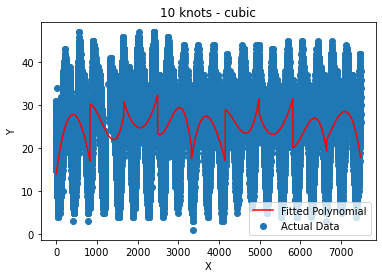

Model: 365 knots - cubic MSE: 28.658481149245166


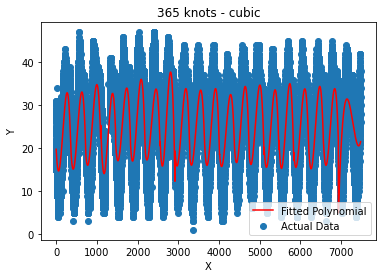

Model: 365 knots - linear, MSE: 46.91963189348463


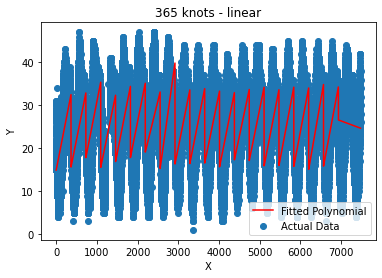

In [37]:
# fit a local polynomial with the given order to the data

# uniform knot selection
knots = np.linspace(min(X),max(X),10)[1:-1]
Y_pred, mse = fit_local_polynomial(X,Y,3,knots)

print(f"Model: 10 knots - cubic, MSE: {mse}")
# plot results here
plt.scatter(X, Y, label='Actual Data')
plt.plot(X, Y_pred, color='red', label='Fitted Polynomial')
plt.title("10 knots - cubic")
plt.xlabel('X')
plt.ylabel('Y')
plt.legend()
plt.show()


# knots every 365 
knots = np.arange(min(X),max(X),365)[1:-1]
Y_pred, mse = fit_local_polynomial(X,Y,3,knots)

print(f"Model: 365 knots - cubic MSE: {mse}")

plt.scatter(X, Y, label='Actual Data')
plt.plot(X, Y_pred, color='red', label='Fitted Polynomial')
plt.title("365 knots - cubic")
plt.xlabel('X')
plt.ylabel('Y')
plt.legend()
plt.show()


# linear vs cubic
Y_pred, mse = fit_local_polynomial(X,Y,1,knots)

print(f"Model: 365 knots - linear, MSE: {mse}")

plt.scatter(X, Y, label='Actual Data')
plt.plot(X, Y_pred, color='red', label='Fitted Polynomial')
plt.title("365 knots - linear")
plt.xlabel('X')
plt.ylabel('Y')
plt.legend()
plt.show()

For 365 knots, Linear polynomial has lower mse as compared to cubic polynomial suggesting better model fit and prediction performance. It indicates that linear order is better in capturing the variations within the bins. <br> 

The placement of knots significantly impacts the resulting fit and model performance. <br>
10 knots result in a simpler model that captures only general trends or large-scale variations in the data. It lacks the granularity to capture subtle changes or local variations effectively. This leads to an oversimplified representation of the data. <br>
365 knots create a model that's very sensitive to individual data points. It can capture intricate details and align with significant changes or transitions in the data. But it's prone to overfitting and might not generalize well to unseen data.

## Smoothing Splines
Use the pre-processed data X_unique and Y_unique to avoid issues with the scipy implementation.

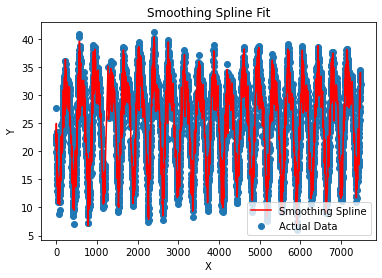

In [38]:
from scipy.interpolate import UnivariateSpline
# average duplicates in X
X_unique = np.unique(X)
Y_unique = np.zeros_like(X_unique)
for i in range(len(X_unique)):
    Y_unique[i] = np.mean(Y[X==X_unique[i]])

# fit smoothing spline here
spline = UnivariateSpline(X_unique, Y_unique)
spline_y = spline(X_unique)

# Visualize the results
plt.scatter(X_unique, Y_unique, label='Actual Data')
plt.plot(X_unique, spline_y, color='red', label='Smoothing Spline')
plt.title('Smoothing Spline Fit')
plt.xlabel('X')
plt.ylabel('Y')
plt.legend()
plt.show()

The main differences and advantages of smoothing splines compared to piecewise polynomial regression lie in their approach to fitting the data, handling smoothness, and their adaptability to capture varying complexities within the dataset.<br>
Smoothing splines fit a single curve over the entire range of data points, considering all observations simultaneously. They aim to find a smooth function that best fits the entire dataset, rather than segmenting it into distinct regions.

In [39]:
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error

# optimal smoothing parameter
s_0 = len(X_unique)*np.std(Y_unique)
# grid of smoothing parameters
candidates = [s_0/50,s_0/25,s_0/10,s_0/5,s_0/2,s_0,s_0]

# determine the best smoothing parameter s here

# use cross validation to find the best smoothing parameter
# split the data into 5 folds

best_s = None
best_mse = float('inf')  # Set to infinity initially

kf = KFold(n_splits=5, shuffle=True, random_state=42)

for s in candidates:
    mse_list = []  # List to store MSE for each fold
    for train_index, val_index in kf.split(X_unique):
        X_train, X_val = X_unique[train_index], X_unique[val_index]
        Y_train, Y_val = Y_unique[train_index], Y_unique[val_index]

        # Fit a smoothing spline using the current s
        spline = UnivariateSpline(X_train, Y_train, s=s)
        spline_y_val = spline(X_val)

        # Calculate MSE for the current fold and s
        mse_fold = mean_squared_error(Y_val, spline_y_val)
        mse_list.append(mse_fold)

    # Average MSE across folds for the current s
    avg_mse = np.mean(mse_list)

    # Check if current s provides a better model
    if avg_mse < best_mse:
        best_mse = avg_mse
        best_s = s
        
# Print the best smoothing parameter and corresponding MSE
print(f"Best Smoothing Parameter: {best_s}")
print(f"Corresponding MSE: {best_mse}")

Best Smoothing Parameter: 5459.669794000886
Corresponding MSE: 2.454696539121133
